<a href="https://colab.research.google.com/github/poojanpatelalpesh/neural-style-transfer-pytorch/blob/main/Neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [4]:
from google.colab import files

uploaded = files.upload()


Saving content.JPG to content.JPG
Saving style.jpg to style (1).jpg


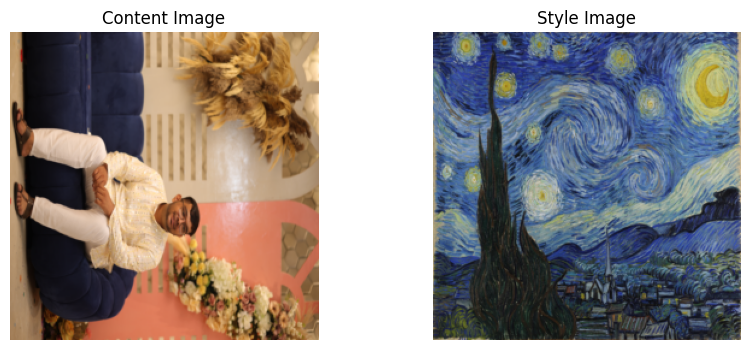

In [18]:
image_size = 512 if torch.cuda.is_available() else 256

loader = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

def load_image(image_name):
    image = Image.open(image_name).convert("RGB")
    image = loader(image).unsqueeze(0)
    return image.to(device)

content_img = load_image("content.JPG")
style_img = load_image("style.jpg")

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    plt.axis("off")
    if title:
        plt.title(title)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
imshow(content_img, "Content Image")
plt.subplot(1,2,2)
imshow(style_img, "Style Image")


In [19]:
vgg = models.vgg19(pretrained=True).features.to(device).eval()

for param in vgg.parameters():
    param.requires_grad = False


In [20]:
content_layers = ['21']   # conv4_2
style_layers = ['0', '5', '10', '19', '28']



In [21]:
def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    features = tensor.view(c, h * w)
    gram = torch.mm(features, features.t())
    return gram


In [22]:
def get_features(image, model):
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in content_layers:
            features['content'] = x
        if name in style_layers:
            features[name] = x
    return features


In [23]:
content_features = get_features(content_img, vgg)
style_features = get_features(style_img, vgg)

style_grams = {layer: gram_matrix(style_features[layer])
               for layer in style_features}


In [24]:
generated = content_img.clone().requires_grad_(True).to(device)


In [25]:
optimizer = optim.Adam([generated], lr=0.003)

style_weight = 1e6
content_weight = 1


Step 0, Total loss: 10056805384192.00


Step 20, Total loss: 2812432875520.00


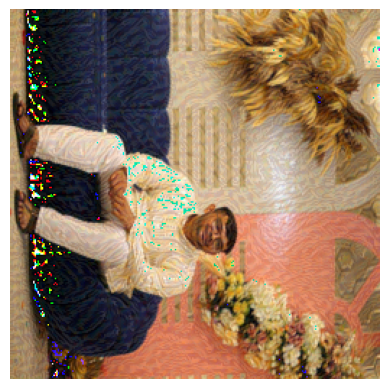

Step 40, Total loss: 2007310008320.00


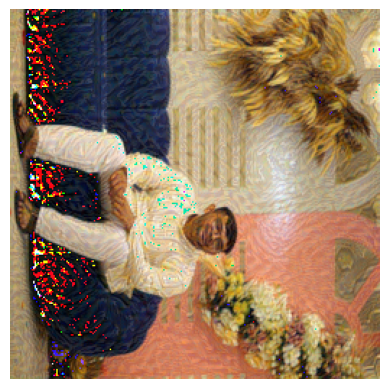

Step 60, Total loss: 1550843510784.00


Step 80, Total loss: 1218552135680.00


Step 100, Total loss: 948767621120.00


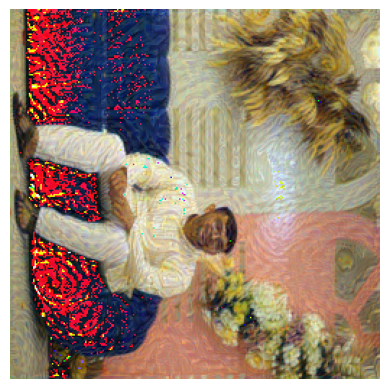

Step 120, Total loss: 727346380800.00


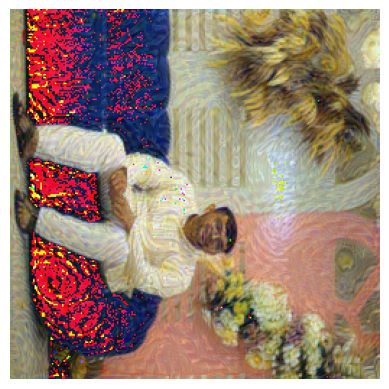

Step 140, Total loss: 551444217856.00


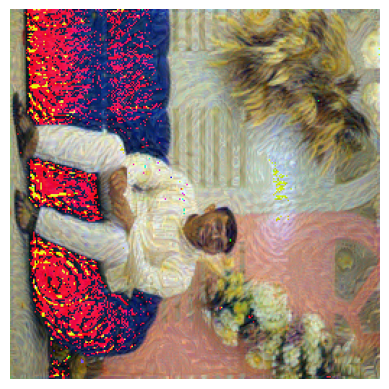

Step 160, Total loss: 417185366016.00


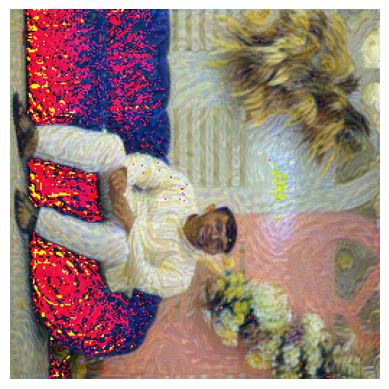

Step 180, Total loss: 318099914752.00


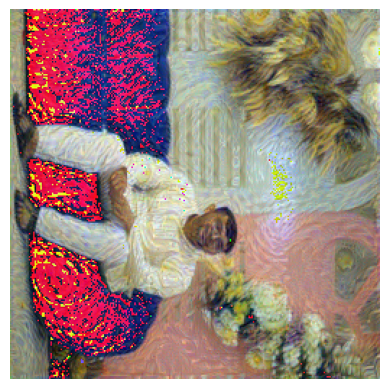

Step 200, Total loss: 246729293824.00


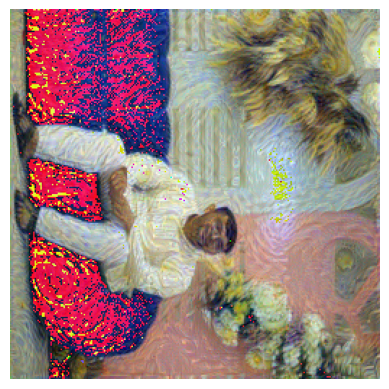

Step 220, Total loss: 196046028800.00


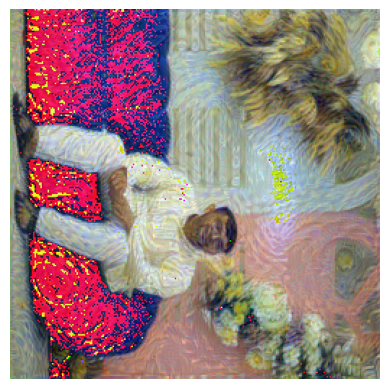

Step 240, Total loss: 160125829120.00


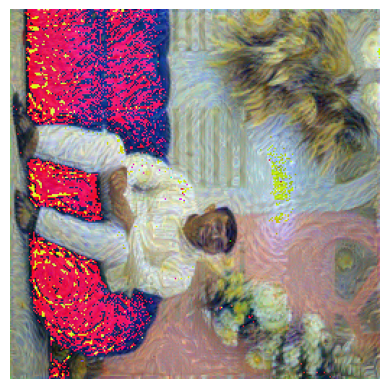

Step 260, Total loss: 134456639488.00


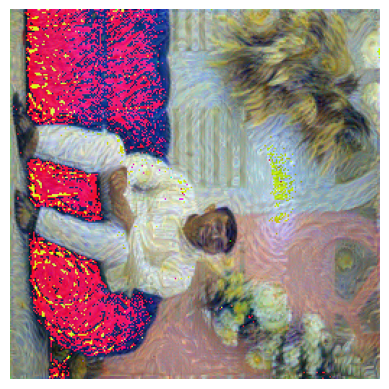

Step 280, Total loss: 115736084480.00


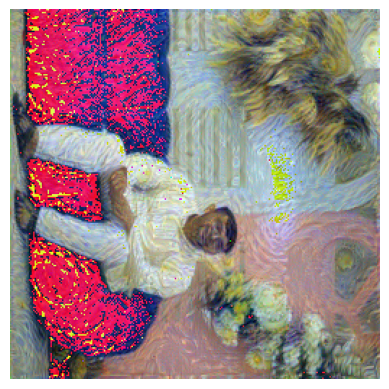

In [26]:
steps = 300
frames = []

for step in range(steps):
    generated_features = get_features(generated, vgg)

    # Content loss
    content_loss = torch.mean(
        (generated_features['content'] - content_features['content'])**2
    )

    # Style loss
    style_loss = 0
    for layer in style_layers:
        gen_feature = generated_features[layer]
        gen_gram = gram_matrix(gen_feature)
        style_gram = style_grams[layer]
        style_loss += torch.mean((gen_gram - style_gram)**2)

    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # Save frame every 20 steps
    if step % 20 == 0:
        print(f"Step {step}, Total loss: {total_loss.item():.2f}")

        img = generated.detach().cpu().clone()
        img = img.squeeze(0)
        img = transforms.ToPILImage()(img)
        frames.append(img)

        plt.imshow(img)
        plt.axis("off")
        plt.show()


In [27]:
frames[0].save(
    "style_evolution.gif",
    save_all=True,
    append_images=frames[1:],
    duration=120,
    loop=0
)

print("GIF saved as style_evolution.gif")


GIF saved as style_evolution.gif
